In [218]:
# Pedro Jorge Oliveira Câmara
# DRE: 120182069

from numpy.random import exponential
from heapq import *
from typing import Callable, Tuple, List

import numpy as np
import matplotlib.pyplot as plt


np.random.default_rng(1)

Generator(PCG64) at 0x7FD0DA7EBE60

In [219]:
def run_simulator(simulator: Callable, lambda_: float, mi_: float, n_iterations: int):
    """
    Roda o simulador e plota o gráfico do resultado obtido.
    :param simulator: função do simulador que será rodado
    :param lambda_: parâmetro lambda para o simulador
    :param mi_: parâmetro mi para o simulador
    :param n_iterations: quantidade de iterações do simulador
    """
    # x: simulation time
    # y: simulation values (number of clients)
    mean_clients, mean_wait_time, x, y = simulator(lambda_, mi_, n_iterations)
    ci_low_clients, ci_high_clients = calculate_confidence_interval(y, mean_clients)
    ci_low_time, ci_high_time = calculate_confidence_interval(x, mean_wait_time)

    print(f"--Mean number of clients: {mean_clients}")
    print(f"--Confidence interval endpoints for mean clients:")
    print(f"Low: {ci_low_clients}")
    print(f"High: {ci_high_time}")
    print(f"--Mean number of waiting: {mean_wait_time}")
    print(f"--Confidence interval endpoints for mean time:")
    print(f"Low: {ci_low_time}")
    print(f"High: {ci_high_time}")

    plt.plot(x, y)
    plt.xlabel("Simulation time")
    plt.ylabel("Number of clients")
    plt.show()

In [220]:
def calculate_confidence_interval(sample: List, sample_mean: float) -> Tuple:
    sum = 0
    n = len(sample)
    for e in sample:
        sum += np.power((e - sample_mean), 2)

    std = np.sqrt(sum / (n-1))
    low = sample_mean - 1.96*(std/np.sqrt(n))
    high = sample_mean + 1.96*(std/np.sqrt(n))

    return low, high

In [221]:
def simulator_1(lambda_: float, mi_: float, n_iterations: int) -> Tuple[float, float, List, List]:
    """
    Implementação do simulador 1.
    :param lambda_: taxa de chegada de clientes
    :param mi_: taxa de serviço
    :param n_iterations: número de rodadas
    """
    queue_len = 0
    simulation_time = 0.0

    X = [queue_len]
    simulation_time_list = [simulation_time]

    sample_departure_list = []
    for i in range(n_iterations):
        sample_arrival = exponential(lambda_)
        sample_departure = exponential(1/mi_)

        if queue_len == 0:
            simulation_time += sample_arrival
            print(f"{simulation_time:08.4f} {'arrival':>10} {queue_len}-->{queue_len+1}")
            queue_len += 1

        else:
            if sample_arrival < sample_departure:
                simulation_time += sample_arrival
                print(f"{simulation_time:08.4f} {'arrival':>10} {queue_len}-->{queue_len+1}")
                queue_len += 1

            else:
                simulation_time += sample_departure
                print(f"{simulation_time:08.4f} {'departure':>10} {queue_len}-->{queue_len-1}")
                queue_len -= 1

        X.append(queue_len)
        simulation_time_list.append(simulation_time)
        sample_departure_list.append(sample_departure)

    mean_clients = sum(X) / simulation_time_list[-1]
    mean_wait_time = sum(sample_departure_list) / len(sample_departure_list)
    return mean_clients, mean_wait_time, simulation_time_list, X

In [222]:
def simulator_2_no_heap(lambda_: float, mi_: float, n_iterations: int) -> Tuple[float, float, List, List]:
    """
    Implementação do simulador 2, sem utilizar a heapq do python.
    :param lambda_: taxa de chegada de clientes
    :param mi_: taxa de serviço
    :param n_iterations: número de rodadas
    """
    n = 0
    simultime = 0
    ARRIVAL = 1
    DEPARTURE = 2
    eventqueue = np.zeros((2, 2))
    eventqueue[0, 0] = exponential(lambda_)
    eventqueue[0, 1] = ARRIVAL
    nelements = 1
    simulation_time_list = [eventqueue[0, 0]]
    X = [1]

    sample_departure_list = []

    for i in range(n_iterations):
        if nelements == 0:
            break

        current_event_time = eventqueue[0, 0]
        current_event_type = eventqueue[0, 1]

        simultime = current_event_time

        nelements -= 1
        if nelements >= 1:
            eventqueue[0, 0] = eventqueue[1, 0]
            eventqueue[0, 1] = eventqueue[1, 1]


        if current_event_type == ARRIVAL:
            print(f'{simultime:08.4f} {"arrival":>10} {n}=>{n + 1}')
            n += 1
            time_next_arrival = exponential(lambda_)

            if nelements == 0:
                time_next_service = exponential(1/mi_)

                if time_next_arrival < time_next_service:
                    eventqueue[1, 0] = simultime + time_next_service
                    eventqueue[1, 1] = DEPARTURE
                    eventqueue[0, 0] = simultime + time_next_arrival
                    eventqueue[0, 1] = ARRIVAL
                    nelements += 2

                else:
                    eventqueue[0, 0] = simultime + time_next_service
                    eventqueue[0, 1] = DEPARTURE
                    eventqueue[1, 0] = simultime + time_next_arrival
                    eventqueue[1, 1] = ARRIVAL
                    nelements += 2

                sample_departure_list.append(time_next_service)

            elif eventqueue[0, 0] > simultime + time_next_arrival:
                eventqueue[1, 0] = eventqueue[0, 0]
                eventqueue[1, 1] = eventqueue[0, 1]
                eventqueue[0, 0] = simultime + time_next_arrival
                eventqueue[0, 1] = ARRIVAL
                nelements += 1

            else:
                eventqueue[1, 0] = simultime + time_next_arrival
                eventqueue[1, 1] = ARRIVAL
                nelements += 1

        else:
            print(f'{simultime:08.4f} {"departure":>10} {n}=>{n - 1}')
            n -= 1

            if n > 0:
                time_next_service = np.random.exponential(1/mi_)

                if eventqueue[0, 0] < simultime + time_next_service:
                    eventqueue[1, 0] = simultime + time_next_service
                    eventqueue[1, 1] = DEPARTURE
                    nelements += 1

                else:
                    eventqueue[1, 0] = eventqueue[0, 0]
                    eventqueue[1, 1] = eventqueue[0, 1]
                    eventqueue[0, 0] = simultime + time_next_service
                    eventqueue[0, 1] = DEPARTURE
                    nelements += 1

                sample_departure_list.append(time_next_service)

        X.append(n)
        simulation_time_list.append(simultime)

    mean_wait_list = sum(sample_departure_list) / len(sample_departure_list)
    mean_clients = sum(X) / simulation_time_list[-1]

    return mean_clients, mean_wait_list, simulation_time_list, X

In [223]:
# não funcional
# deixando para mostrar o que fiz
def simulator_2(lambda_: float, mi_: float, n_iterations: int) -> Tuple[float, float, List, List]:
    """
    Implementação do simulador 2 utilizando a heapq do python. Tentativa de simplificação do método `simulator_2_no_heap`, mas não está funcionando :(
    :param lambda_: taxa de chegada de clientes
    :param mi_: taxa de serviço
    :param n_iterations: número de rodadas
    """
    ARRIVAL, DEPARTURE = 1, 2
    n = 0
    first_arrival_time = exponential(lambda_)
    simulation_time = 0
    first_client = (ARRIVAL, first_arrival_time)
    p_queue = [first_client]
    heapify(p_queue)

    X = [1]
    simulation_time_list = [simulation_time]

    for i in range(n_iterations):
        if len(p_queue) == 0:
            break

        current_client = heappop(p_queue)
        current_event_type = current_client[0]
        current_event_time = current_client[1]

        simulation_time = current_event_time

        if current_event_type == ARRIVAL:
            n += 1
            time_next_arrival = exponential(lambda_)

            if len(p_queue) == 0:
                time_next_service = exponential(1/mi_)
                heappush(p_queue, (simulation_time+time_next_service, DEPARTURE))
                heappush(p_queue, (simulation_time+time_next_arrival, ARRIVAL))

            else:
                heappush(p_queue, (simulation_time+time_next_arrival, ARRIVAL))

        else: # current_event_type == DEPARTURE
            n -= 1

            if n > 0:
                time_next_service = exponential(1/mi_)
                heappush(p_queue, (simulation_time+time_next_service, DEPARTURE))

        X.append(n)
        simulation_time_list.append(simulation_time)

    mean_clients = sum(X) / simulation_time_list[-1]

    return mean_clients, 0, simulation_time_list, X

000.4362    arrival 0-->1
000.7353  departure 1-->0
003.4904    arrival 0-->1
003.5769  departure 1-->0
003.8258    arrival 0-->1
003.9069  departure 1-->0
003.9362    arrival 0-->1
004.1354    arrival 1-->2
005.2516  departure 2-->1
005.5608  departure 1-->0
009.7467    arrival 0-->1
010.7323  departure 1-->0
010.7785    arrival 0-->1
010.7798  departure 1-->0
011.9375    arrival 0-->1
012.0378    arrival 1-->2
012.0736  departure 2-->1
012.0983  departure 1-->0
012.6179    arrival 0-->1
012.8202  departure 1-->0
013.1907    arrival 0-->1
013.5953    arrival 1-->2
013.8632  departure 2-->1
014.0242  departure 1-->0
014.4651    arrival 0-->1
014.8786  departure 1-->0
016.6226    arrival 0-->1
017.4289  departure 1-->0
019.1061    arrival 0-->1
019.2614  departure 1-->0
020.8166    arrival 0-->1
021.0938  departure 1-->0
021.4814    arrival 0-->1
021.8461  departure 1-->0
023.2341    arrival 0-->1
023.9365    arrival 1-->2
024.0815    arrival 2-->3
024.4761  departure 3-->2
025.3873    

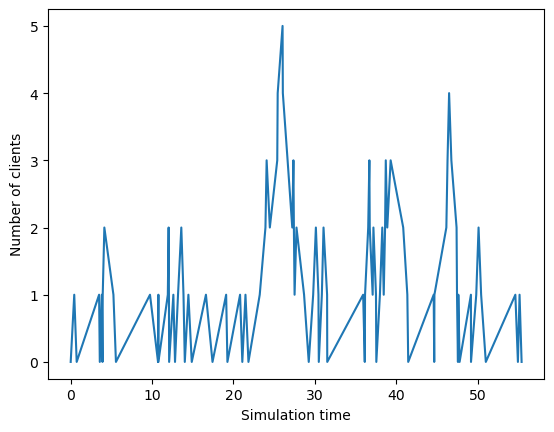

In [224]:
run_simulator(simulator_1, lambda_=1.0, mi_=2.0, n_iterations=100)


000.1438    arrival 0=>1
000.2036    arrival 1=>2
000.4830    arrival 2=>3
000.5120  departure 3=>2
000.7751  departure 2=>1
000.9291  departure 1=>0
001.3849    arrival 0=>1
001.7306  departure 1=>0
002.8224    arrival 0=>1
002.8894  departure 1=>0
006.0171    arrival 0=>1
006.7164  departure 1=>0
006.9601    arrival 0=>1
007.0582    arrival 1=>2
007.2651    arrival 2=>3
007.5639  departure 3=>2
007.9933  departure 2=>1
009.5940    arrival 1=>2
009.6115  departure 2=>1
011.0246  departure 1=>0
012.5411    arrival 0=>1
013.0148  departure 1=>0
013.2572    arrival 0=>1
013.3050  departure 1=>0
014.0834    arrival 0=>1
014.6523  departure 1=>0
015.4384    arrival 0=>1
015.5068  departure 1=>0
019.9796    arrival 0=>1
020.8791    arrival 1=>2
021.2155    arrival 2=>3
021.8992  departure 3=>2
021.9443  departure 2=>1
021.9475  departure 1=>0
022.5248    arrival 0=>1
022.5896  departure 1=>0
023.5114    arrival 0=>1
023.6139  departure 1=>0
024.0509    arrival 0=>1
024.1201  departure 1=>0


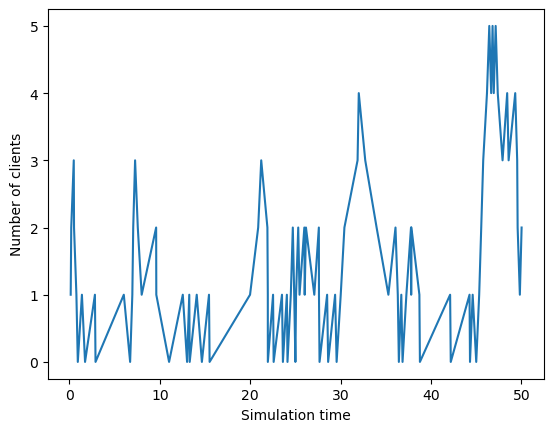

In [225]:
run_simulator(simulator_2_no_heap, lambda_=1.0, mi_=2.0, n_iterations=100)

000.5552    arrival 0-->1
001.1909  departure 1-->0
004.5661    arrival 0-->1
005.1396  departure 1-->0
005.4433    arrival 0-->1
005.4630  departure 1-->0
010.9606    arrival 0-->1
011.0288  departure 1-->0
012.8331    arrival 0-->1
012.9355  departure 1-->0
016.5571    arrival 0-->1
016.6638  departure 1-->0
017.7741    arrival 0-->1
017.8443  departure 1-->0
021.4935    arrival 0-->1
021.6900  departure 1-->0
021.7765    arrival 0-->1
022.4658  departure 1-->0
023.9752    arrival 0-->1
024.0317  departure 1-->0
027.7835    arrival 0-->1
027.8352  departure 1-->0
028.1005    arrival 0-->1
028.6073  departure 1-->0
029.1913    arrival 0-->1
029.4660    arrival 1-->2
030.5466  departure 2-->1
030.7524  departure 1-->0
033.6866    arrival 0-->1
033.6958  departure 1-->0
034.0266    arrival 0-->1
034.1921  departure 1-->0
034.9424    arrival 0-->1
035.0818  departure 1-->0
036.3467    arrival 0-->1
036.3753  departure 1-->0
036.4766    arrival 0-->1
036.7512  departure 1-->0
043.5236    

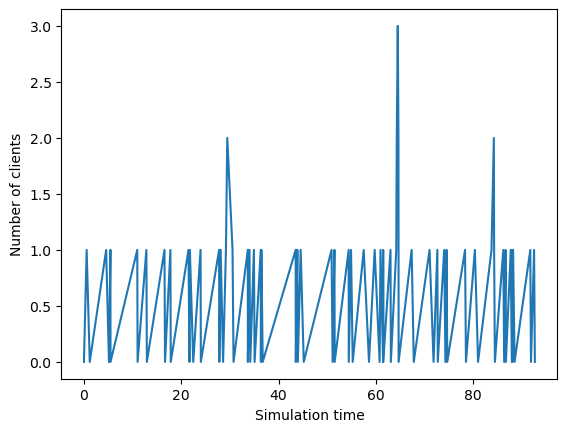

In [226]:
run_simulator(simulator_1, lambda_=2.0, mi_=4.0, n_iterations=100)

001.9745    arrival 0=>1
002.6817  departure 1=>0
003.6258    arrival 0=>1
003.7270  departure 1=>0
008.6131    arrival 0=>1
008.8584  departure 1=>0
008.9979    arrival 0=>1
009.2061  departure 1=>0
009.5937    arrival 0=>1
009.8293  departure 1=>0
010.7787    arrival 0=>1
010.9944  departure 1=>0
013.7732    arrival 0=>1
014.1098  departure 1=>0
015.5810    arrival 0=>1
015.9826    arrival 1=>2
016.2508  departure 2=>1
017.5422    arrival 1=>2
017.7874  departure 2=>1
017.9729  departure 1=>0
020.0159    arrival 0=>1
020.1795  departure 1=>0
021.0505    arrival 0=>1
021.2611  departure 1=>0
024.4838    arrival 0=>1
024.7302  departure 1=>0
027.3215    arrival 0=>1
027.3753    arrival 1=>2
027.5111    arrival 2=>3
027.5528  departure 3=>2
027.5802  departure 2=>1
027.6552    arrival 1=>2
027.7238    arrival 2=>3
027.9786  departure 3=>2
028.4654  departure 2=>1
028.5365  departure 1=>0
035.8329    arrival 0=>1
035.9143  departure 1=>0
036.8609    arrival 0=>1
037.0877  departure 1=>0


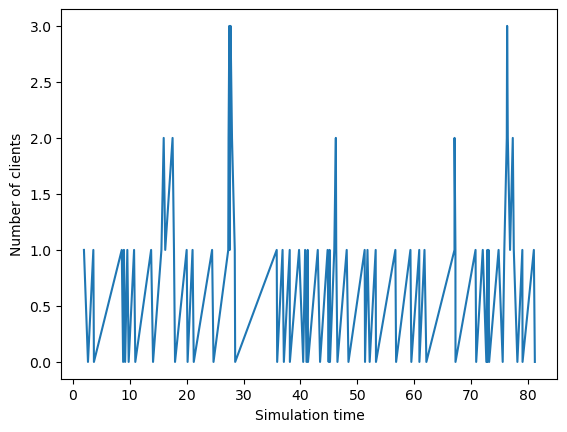

In [227]:
run_simulator(simulator_2_no_heap, lambda_=2.0, mi_=4.0, n_iterations=100)

000.5172    arrival 0-->1
001.0700  departure 1-->0
001.7331    arrival 0-->1
001.7737  departure 1-->0
002.7301    arrival 0-->1
002.8955  departure 1-->0
003.4617    arrival 0-->1
003.6455  departure 1-->0
003.6983    arrival 0-->1
004.1645  departure 1-->0
009.0093    arrival 0-->1
009.1584  departure 1-->0
009.4101    arrival 0-->1
009.6937    arrival 1-->2
010.3218  departure 2-->1
010.6131  departure 1-->0
011.2058    arrival 0-->1
011.2701    arrival 1-->2
011.4801    arrival 2-->3
012.1203  departure 3-->2
012.1378  departure 2-->1
012.6438  departure 1-->0
014.0913    arrival 0-->1
014.3345  departure 1-->0
015.4694    arrival 0-->1
015.5851  departure 1-->0
015.7338    arrival 0-->1
015.7949    arrival 1-->2
015.9688  departure 2-->1
015.9715  departure 1-->0
017.4723    arrival 0-->1
017.4780  departure 1-->0
017.6455    arrival 0-->1
018.0614  departure 1-->0
020.9339    arrival 0-->1
021.1162  departure 1-->0
021.7736    arrival 0-->1
022.4160  departure 1-->0
022.6863    

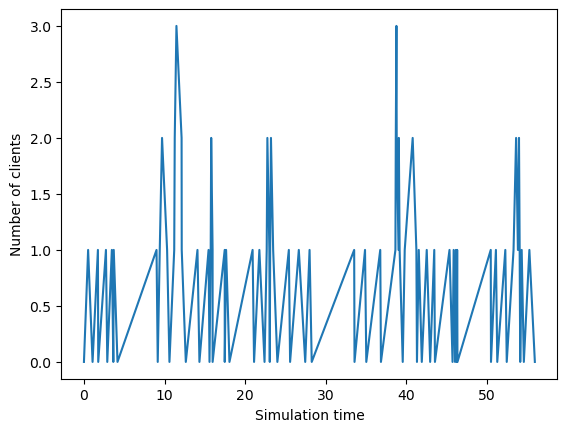

In [228]:
run_simulator(simulator_1, lambda_=1.0, mi_=4.0, n_iterations=100)

000.1153    arrival 0=>1
000.4033  departure 1=>0
000.5426    arrival 0=>1
000.6874  departure 1=>0
000.7367    arrival 0=>1
000.9845  departure 1=>0
004.0368    arrival 0=>1
004.0382  departure 1=>0
004.2438    arrival 0=>1
004.3670  departure 1=>0
004.9368    arrival 0=>1
005.0318  departure 1=>0
007.7658    arrival 0=>1
007.8247  departure 1=>0
011.7706    arrival 0=>1
011.8088    arrival 1=>2
011.8745  departure 2=>1
012.0028  departure 1=>0
014.8218    arrival 0=>1
014.9047  departure 1=>0
014.9699    arrival 0=>1
015.0515    arrival 1=>2
015.0528  departure 2=>1
015.5642  departure 1=>0
016.5065    arrival 0=>1
016.6241  departure 1=>0
016.8650    arrival 0=>1
017.0577    arrival 1=>2
017.1718    arrival 2=>3
017.2827  departure 3=>2
017.4045  departure 2=>1
017.4122  departure 1=>0
017.7632    arrival 0=>1
018.3752  departure 1=>0
020.5211    arrival 0=>1
020.5480  departure 1=>0
020.6949    arrival 0=>1
020.7969  departure 1=>0
021.0520    arrival 0=>1
021.3650    arrival 1=>2


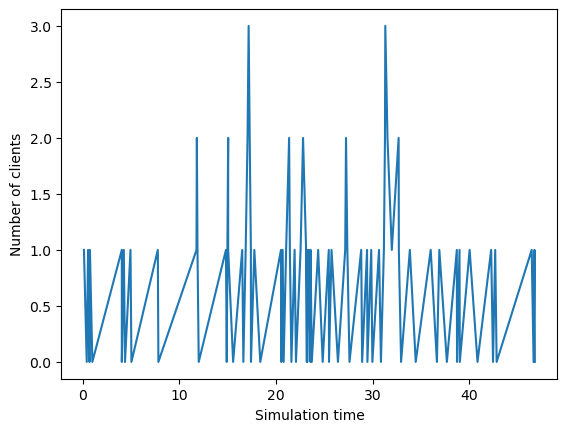

In [229]:
run_simulator(simulator_2_no_heap, lambda_=1.0, mi_=4.0, n_iterations=100)

In [230]:
# não funcional
# run_simulator(simulator_2, lambda_=1.0, mi_=2.0, n_iterations=100)
# run_simulator(simulator_2, lambda_=2.0, mi_=4.0, n_iterations=100)
# run_simulator(simulator_2, lambda_=1.0, mi_=4.0, n_iterations=100)
